In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import os
os.chdir(r"C:\Users\kaborg15\Python_projects\Vibrent_Style_Quiz_Generation")

import pandas as pd
from resources.constants import *
from src import load_dataframes

outfits_df = load_dataframes.load_pickle(DATA_SAVE_PATH, OUTFITS_PATH)
pictures_df = pd.read_csv(PICTURE_TRIPLETS_CSV_PATH, sep=CSV_SEPARATOR)
user_triplets_df = pd.read_csv(USER_ACTIVITY_TRIPLETS_CSV_PATH, sep=CSV_SEPARATOR)
# For the purposes of this notebook, we're not interested in duplicate outfits
outfits_df = outfits_df.groupby("group").first().reset_index()

In [2]:
import numpy as np

def get_outfit_category(tag_categories, tags, category):
    tag_categories, tags = np.array(tag_categories), np.array(tags)
    category_indexes = np.where(tag_categories == category)[0]
    if len(category_indexes) == 0:
        return []
    cat_tags = tags[category_indexes]
    return cat_tags

outfits_df["category"] = outfits_df.apply(lambda x: get_outfit_category(x["tag_categories"], x["outfit_tags"], "Category"), axis=1)
outfit_category_dict = outfits_df[["id", "category"]].set_index("id").to_dict()["category"]

In [3]:
user_rentals_df = user_triplets_df.groupby("customer.id").agg({"outfit.id": list}).reset_index()

In [4]:
def get_outfit_categories(outfit_ids, outfits_to_categories):
    return [category for outfit_id in outfit_ids for category in outfits_to_categories.get(outfit_id, [])]

user_rentals_df["outfit_categories"] = user_rentals_df["outfit.id"].apply(lambda x: get_outfit_categories(x, outfit_category_dict))
user_rentals_df["num_rentals"] = user_rentals_df["outfit.id"].apply(len)

In [5]:

# Calculate Simpson Diversity Index, measuring the probability that two items randomly selected from the dataset will be of different categories
def calculate_simpson_diversity(categories):
    categories = np.array(categories)
    unique_categories, category_counts = np.unique(categories, return_counts=True)
    category_probs = category_counts / category_counts.sum()
    return 1 - np.sum(category_probs ** 2)

def simpson_di(categories):

    """ Given a hash { 'species': count } , returns the Simpson Diversity Index
    
    >>> simpson_di({'a': 10, 'b': 20, 'c': 30,})
    0.3888888888888889
    """

    def p(n, N):
        if n ==  0:
            return 0
        else:
            return float(n)/N

    unique_categories, category_counts = np.unique(categories, return_counts=True)
    N = sum(category_counts)
    
    return sum(p(n, N)**2 for n in category_counts if n != 0)

#user_rentals_df["simpson_diversity"] = user_rentals_df["outfit_categories"].apply(calculate_simpson_diversity)
user_rentals_df["simpson_diversity"] = user_rentals_df["outfit_categories"].apply(simpson_di)
user_rentals_df[user_rentals_df["num_rentals"] > 4]["simpson_diversity"].mean()

np.float64(0.2865477913227337)

In [6]:
import pickle

# Load pre-computed embeddings from pickle to outfits_df

PICKLED_DICT_PATH = r"resources\data\dataset\embeddings\EfficientNet_V2_L_final_dict.pkl"
with open(PICKLED_DICT_PATH, "rb") as f:
    embeddings_dict = pickle.load(f)

pictures_df["embedding"] = pictures_df["picture.id"].apply(lambda x: embeddings_dict[x])
# Sort displayorder beforehand to ensure embeddings are in the correct order
pictures_dict = pictures_df.sort_values("displayOrder").groupby("outfit.id").agg({"embedding": list, "displayOrder":list, "picture.id": list}).to_dict()
outfits_to_embeddings_dict = pictures_dict["embedding"]
outfits_to_pictures_id_dict = pictures_dict["picture.id"]
outfits_df["embeddings"] = outfits_df["id"].apply(lambda x: outfits_to_embeddings_dict.get(x, []))
outfits_df["picture_ids"] = outfits_df["id"].apply(lambda x: outfits_to_pictures_id_dict.get(x, []))
outfits_df["num_pictures"] = outfits_df["embeddings"].apply(len)
# Use the first picture as the a representative embedding for the outfit
example_embedding = outfits_df["embeddings"].iloc[0][0]
dummy_embedding = np.zeros_like(example_embedding)
outfits_df["lead_embedding"] = outfits_df["embeddings"].apply(lambda x: x[0] if len(x) > 0 else dummy_embedding)
outfits_df["lead_picture_id"] = outfits_df["picture_ids"].apply(lambda x: x[0] if len(x) > 0 else None)
print(f"{len(outfits_df[outfits_df['num_pictures'] == 0])} of {len(outfits_df)} outfits have no embeddings")

330 of 9791 outfits have no embeddings


In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

all_tags = outfits_df["outfit_tags"].values.tolist()
mlb = MultiLabelBinarizer()
one_hot_encoded = mlb.fit_transform(all_tags)
outfits_df["one_hot_encoded"] = [np.array(oh_list) for oh_list in one_hot_encoded.tolist()]

In [8]:
outfits_df

,group,id,name,description,owner,timeCreated,retailPrice,meta.validTo,outfit_tags,tag_categories,Outfit_size,category,embeddings,picture_ids,num_pictures,lead_embedding,lead_picture_id,one_hot_encoded
0,group.00064a241ade73e6a5a7ad36327e4e83,outfit.d138f31106ac442f9b2e0fe163597405,New Justine Coat,"The Justine Coat features a high neck, a hidde...",user.3b5555d48f6b473f8e58956aadc0e21f,2021-10-01 10:48:04.675,3500.0000,9999-01-01 00:00:00,"[Synthetic, Multi Season, Everyday, Day Birger...","[Material, Seasons, Occasion, Brand, Size, Col...",[M],[Coats],"[[0.007065, -0.04868, -0.05066, 0.1659, 1.448,...",[picture.7040fcb864074b28bae3c09f66972ed0],1,"[0.007065, -0.04868, -0.05066, 0.1659, 1.448, ...",picture.7040fcb864074b28bae3c09f66972ed0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,group.000957e12deba05e437a5e9726e8002c,outfit.93826cc51216dcd0,Sophisticated Dress,This dress is perfect for a summer night out w...,user.15bee69d2f1541d785eee3f047ec5cf9,2017-05-08 13:28:30.000,10000.0000,9999-01-01 00:00:00,"[Fall, Dresses, XS, Prada, Grey, Women, Business]","[Seasons, Category, Size, Brand, Color, Gender...",[XS],[Dresses],"[[-0.0823, -0.131, 0.2832, -0.1334, -0.08594, ...","[picture.bdfc85951b9babcf, picture.b80df15a205...",6,"[-0.0823, -0.131, 0.2832, -0.1334, -0.08594, -...",picture.bdfc85951b9babcf,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,group.000aad5ac8cfefd8063ee16f6f57b2c1,outfit.edbe38fccd174c3cac918d1347b7811e,Prenestina Jacket Baby Blue Jacket,"Super elegant, constructed jacket with puffed ...",user.0cc54cbd6fa246599239e9adce341264,2022-03-28 13:54:38.895,2500.0000,9999-01-01 00:00:00,"[Cotton, C.L.E.A.N by Christina Ledang, Viscos...","[Material, Brand, Material, Category, Occasion...",[S],[Jackets],"[[1.335, -0.1155, 0.01475, -0.03061, 0.1024, 0...","[picture.3a1be6c7ace347caa0ce0cc495d0ae2c, pic...",4,"[1.335, -0.1155, 0.01475, -0.03061, 0.1024, 0....",picture.3a1be6c7ace347caa0ce0cc495d0ae2c,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,group.00136735b2578e9c5d3264375b6f4804,outfit.5c8d69783c04405081f121d327123521,ZWNo01 Sweater,ZWNo1 is a chunky hand-knit sweater from Bernt...,user.b62e7bd166424c819a2501d83b28b037,2024-01-18 05:23:19.035,6170.0000,9999-01-01 00:00:00,"[Wool, Winter, Purple, L, Knitwear, Everyday, ...","[Material, Seasons, Color, Size, Category, Occ...",[L],"[Knitwear, Sweaters]","[[-0.07965, -0.091, 1.542, 0.07306, 0.2947, -0...","[picture.4dd4267a6ace4b22b03ff2913148d9ee, pic...",2,"[-0.07965, -0.091, 1.542, 0.07306, 0.2947, -0....",picture.4dd4267a6ace4b22b03ff2913148d9ee,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,group.00177dcb8a3afabaa5f899443a92154d,outfit.92a9f025465bd509,Out of stock - Latonia Dress,HAR BLITT HENTET AV EIER 03.09.2017.\nSKAL IKK...,user.a00e19bc644fb8f2,2017-02-13 16:31:31.000,6500.0000,9999-01-01 00:00:00,"[Dresses, Beige, S]","[Category, Color, Size]",[S],[Dresses],"[[0.05737, -0.04572, -0.0863, -0.05783, -0.104...","[picture.b785cc1c1a925b21, picture.abb05badaea...",4,"[0.05737, -0.04572, -0.0863, -0.05783, -0.1046...",picture.b785cc1c1a925b21,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9786,group.ffe3a5c7cf5d53385d918d7175ac9a80,outfit.b1aa45faec994c2bbad4d58e988b3f2e,Hooded Sweater Dress,A cozy hooded sweater dress from IBEN. The dre...,user.b0485ebe4a4b46ccb68cbe187fe101df,2023-02-13 08:33:43.949,1100.0000,9999-01-01 00:00:00,"[IBEN, Wool, Winter, Midi, Everyday, Fall, Dre...","[Brand, Material, Seasons, Length, Occasion, S...",[S],[Dresses],"[[-0.12415, -0.0867, -0.1213, -0.1425, 0.00954...","[picture.baf4dc00564b4580ace0362257e30745, pic...",3,"[-0.12415, -0.0867, -0.1213, -0.1425, 0.00954,...",picture.baf4dc00564b4580ace0362257e30745,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9787,group.ffeff24c94e027a51e16911c18f794e1,outfit.a9b993b2778245f980708ccbe34257f4,Devore Kaftan Maxi Dress Black,Fall in love under the sun and stay fabulous

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

def get_mean_embedding(embeddings):
    embeddings = np.array(embeddings)
    mean_embedding = np.mean(embeddings, axis=0)
    return mean_embedding

def concatenate_embeddings(oh_embeddings, image_embeddings, oh_weighting):
    oh_embeddings = np.array(oh_embeddings) * oh_weighting
    return np.concatenate((oh_embeddings, image_embeddings))

#outfits_df["mean_embeddings"] = outfits_df["embeddings"].apply(lambda x: get_mean_embedding(x))
#one_hot_encoded = np.array(outfits_df["one_hot_encoded"].tolist())
#mean_embeddings = np.array(outfits_df["mean_embeddings"].tolist())

outfits_df["concatenated_embeddings"] = outfits_df.apply(lambda x: concatenate_embeddings(x["one_hot_encoded"], x["lead_embedding"], oh_weighting=4), axis=1)
input_embeddings = outfits_df["concatenated_embeddings"]#np.concatenate((one_hot_encoded, mean_embeddings), axis=1)
input_embeddings = torch.tensor(input_embeddings.tolist(), dtype=torch.float32)




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\kaborg15\AppData\Local\anaconda3\envs\style_quiz\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\kaborg15\AppData\Local\anaconda3\envs\style_quiz\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\kaborg15\AppData\Local\anaconda3\envs\style_quiz\Lib\site-packages\ipykernel\kernel

In [10]:
from tqdm.notebook import tqdm

# Define the autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Assuming the input is normalized between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Define the dimensions
input_dim = input_embeddings.shape[1]
hidden_dim = 2048  # You can adjust this as needed
latent_dim = 512   # You can adjust this as needed

# Instantiate the model, define the loss function and the optimizer
model = Autoencoder(input_dim, hidden_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 3
batch_size = 32

for epoch in tqdm(range(num_epochs)):
    permutation = torch.randperm(input_embeddings.size()[0])
    
    for i in range(0, input_embeddings.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_inputs = input_embeddings[indices]

        # Forward pass
        encoded, decoded = model(batch_inputs)

        # Compute the loss
        loss = criterion(decoded, batch_inputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the model
#torch.save(model.state_dict(), 'autoencoder_model.pth')


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [1/3], Loss: 0.3261
Epoch [2/3], Loss: 0.3261
Epoch [3/3], Loss: 0.2877


In [13]:
import numpy as np
def get_outfit_embeddings(input_embeddings, model):
    with torch.no_grad():
        encoded, decoded = model(input_embeddings)
    return encoded

outfit_embeddings = get_outfit_embeddings(input_embeddings, model)
outfits_df["outfit_embeddings"] = [x.tolist() for x in outfit_embeddings]
print(np.stack(outfits_df["outfit_embeddings"].values).shape)

(9791, 512)


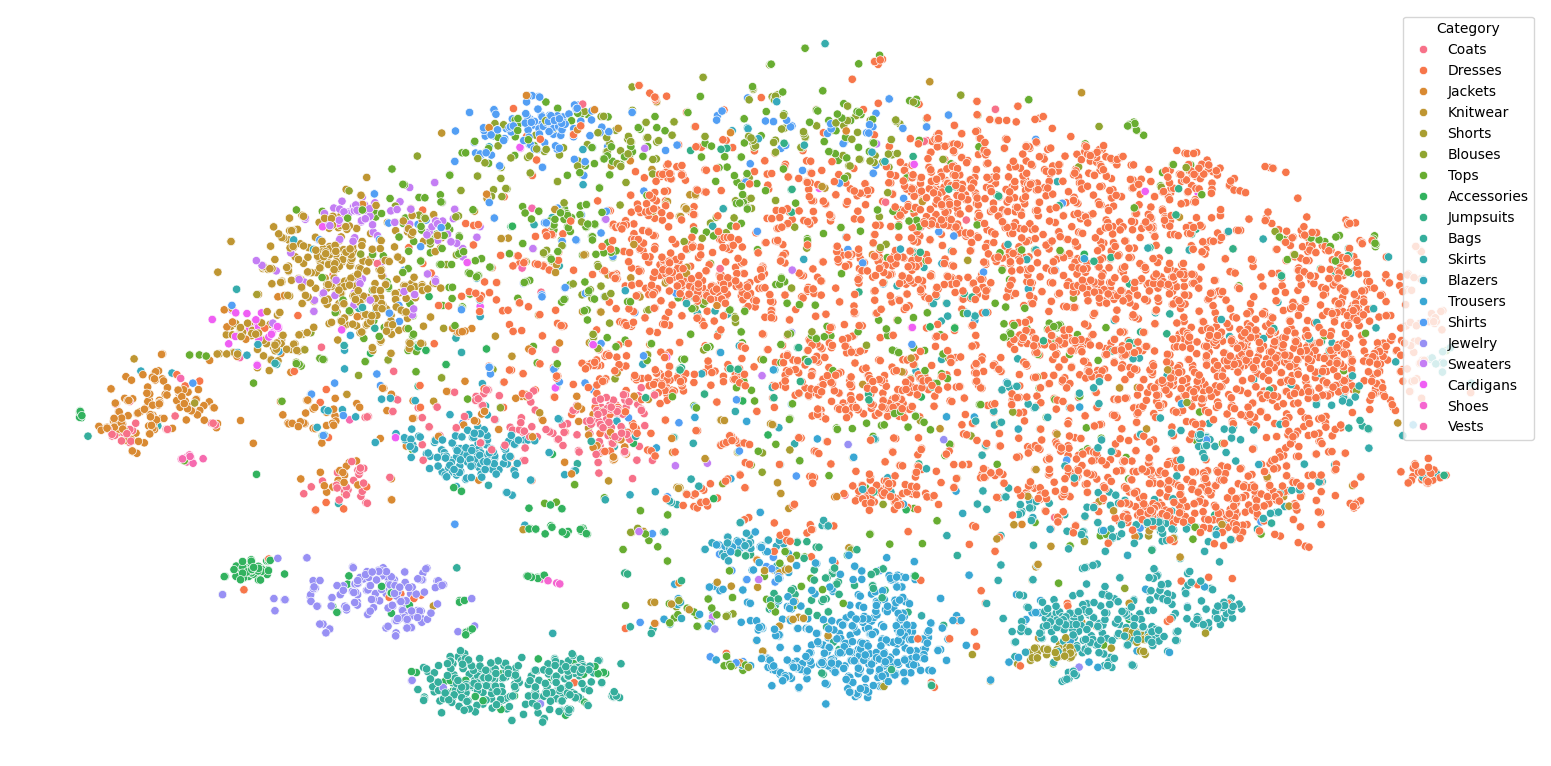

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from src import generate_embedding_tsnes_with_thumbnails

FIGURE_SAVE_PATH = "reports/figures/outfit_tsne.png"

#Generate TSNE diagram of embeddings, but only for outfits with at least one picture
#Save this graph to file to load it into PIL for later editing
tsne_df, scatter_plot = generate_embedding_tsnes_with_thumbnails.generate_tsne_diagram(outfits_df.dropna(subset=["lead_picture_id"]), "outfit_embeddings", show_plot=True, save_path=FIGURE_SAVE_PATH)

c:\Users\kaborg15\AppData\Local\anaconda3\envs\style_quiz\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\kaborg15\AppData\Local\anaconda3\envs\style_quiz\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


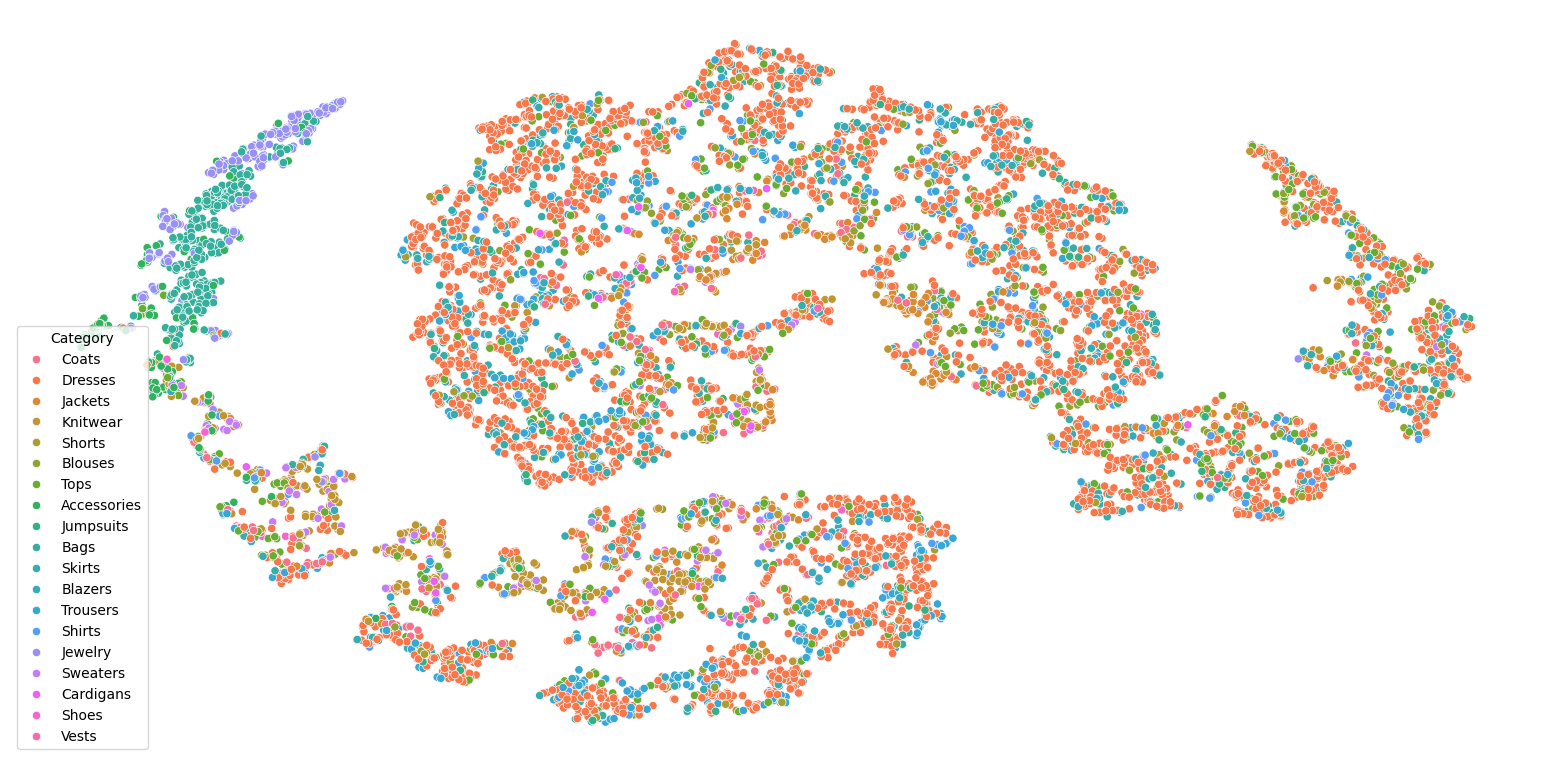

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from src import generate_embedding_tsnes_with_thumbnails

FIGURE_SAVE_PATH = "reports/figures/outfit_tsne.png"


tsne_df, scatter_plot = generate_embedding_tsnes_with_thumbnails.generate_tsne_diagram(outfits_df.dropna(subset=["lead_picture_id"]), "outfit_embeddings", show_plot=True, save_path=FIGURE_SAVE_PATH)

0it [00:00, ?it/s]

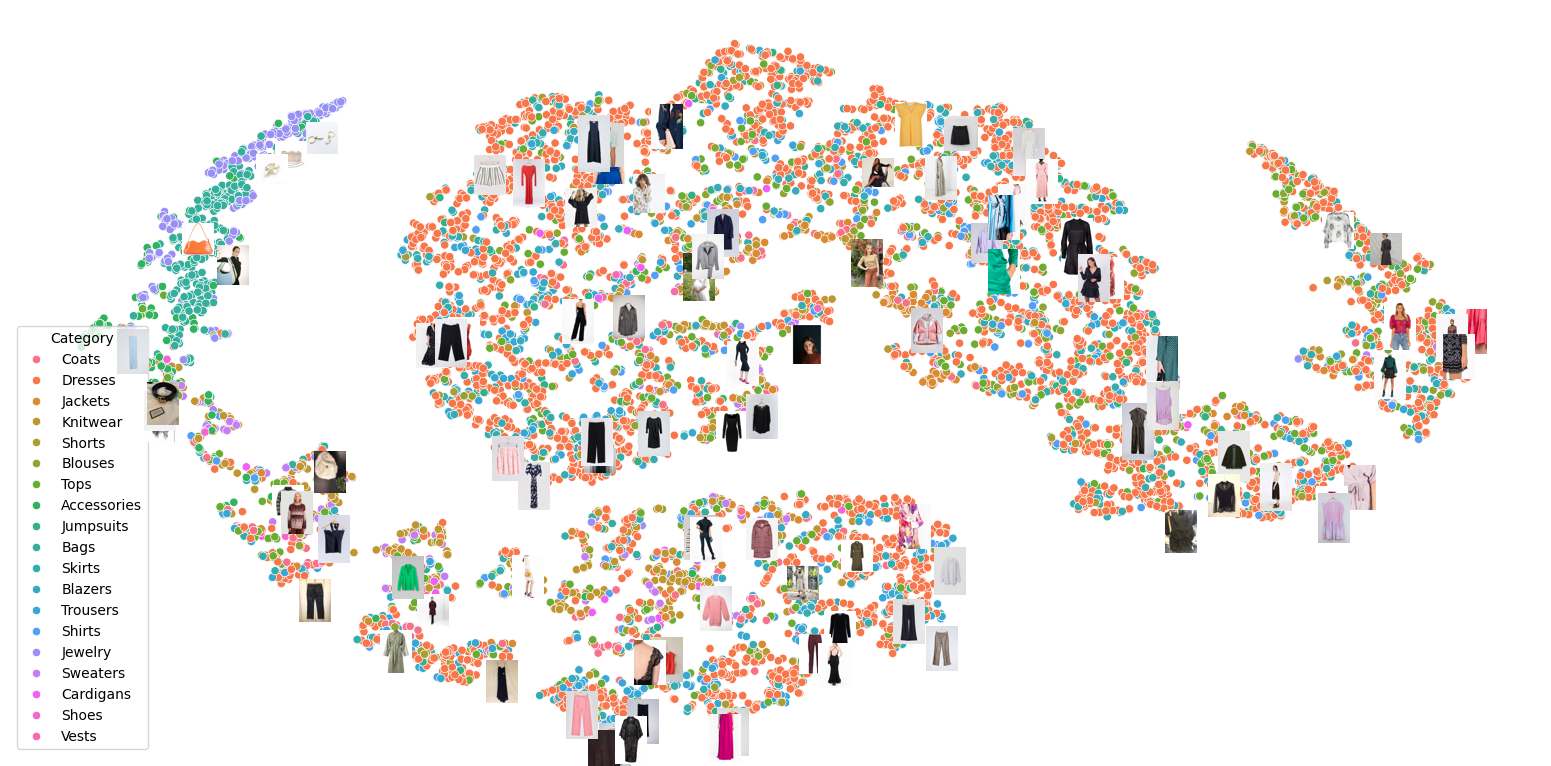

In [18]:
image_with_thumbnails = generate_embedding_tsnes_with_thumbnails.draw_thumbnails_on_scatter_plot(scatter_plot, tsne_df)
display(image_with_thumbnails)

In [14]:
display(image_with_thumbnails)

NameError: name 'image_with_thumbnails' is not defined